In [5]:
!pip install pylablib

  Using cached rpyc-6.0.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached pyft232-0.12.tar.gz (16 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pyusb-1.3.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached PyQt5-5.15.11-cp38-abi3-win_amd64.whl.metadata (2.1 kB)
  Using cached PyQt5_Qt5-5.15.2-py3-none-win_amd64.whl.metadata (552 bytes)
   ---------------------------------------- 1.8/1.8 MB 24.8 MB/s eta 0:00:00
Using cached PyQt5-5.15.11-cp38-abi3-win_amd64.whl (6.9 MB)
   ---------------------------------------- 2.8/2.8 MB 80.3 MB/s eta 0:00:00
Using cached pyusb-1.3.1-py3-none-any.whl (58 kB)
Using cached rpyc-6.0.2-py3-none-any.whl (74 kB)
   ---------------------------------------- 36.3/36.3 MB 76.9 MB/s eta 0:00:00
   ---------------------------------------- 38.1/38.1 MB 43.3 MB/s eta 0:00:00
Using cached PyQt5_Qt5-5.15.2-py3-none-win_amd64.whl (50.1 MB)
   ---------------------------------------- 9.5/9.5 MB 65.5 MB/s eta 0:00:00
  Created wheel for pyft232: filename=pyft232-0.12-py3-none-any.whl size=19446 sha256=df8f3691f6077625c8e1130456e3b716fc2530eb400a8812f212772499cdb894
  Stored in directory: c:\use

In [3]:
import sys 
print(sys.executable)

!{sys.executable} -m pip install astropy

c:\users\burchlab\appdata\local\programs\python\python36\python.exe


In [1]:
from astropy.io import fits 
print("Astropy is ready")

Astropy is ready


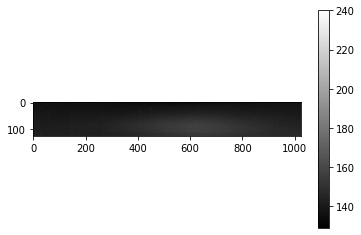

In [24]:
from pylablib.devices import Andor
import threading
import time
import matplotlib.pyplot as plt
import os 
from astropy.io import fits
import numpy as np 

class AndorCameraController:
    def __init__(self):
        self.cam = None
        self.connected = False

        # Cached state (GUI mirrors this)
        self.exposure = 0.1
        self.acquisition_mode = "single"
        self.hbin = 1
        self.vbin = 1
        self.temperature_setpoint = None
        self.cooler_enabled = False

        self._lock = threading.Lock()

    # Connection control
    def connect(self):
        "Open camera connection"
        if not self.connected:
            self.cam = Andor.AndorSDK2Camera()
            self.connected = True

    def disconnect(self):
        "Close camera connection"
        if self.connected:
            self.cam.close()
            self.connected = False


    # Cooling control
    def enable_cooling(self, temperature):
        with self._lock:
            self.cam.set_cooler(True)
            self.cam.set_temperature(temperature)
            self.cooler_enabled = True
            self.temperature_setpoint = temperature

    def disable_cooling(self):
        with self._lock:
            self.cam.set_cooler(False)
            self.cooler_enabled = False

    def get_temperature(self):
        return self.cam.get_temperature()

    # Readout / ROI
    def set_roi(self, hbin=1, vbin=1,
                hstart=0, hend=None,
                vstart=0, vend=None):
        with self._lock:
            self.cam.set_roi(
                hstart=hstart, hend=hend,
                vstart=vstart, vend=vend,
                hbin=hbin, vbin=vbin
            )
            self.hbin = hbin
            self.vbin = vbin
    
    def set_fvb(self):
        with self._lock:
            self.cam.set_roi(vbin="full")
            self.vbin = "full"
    
    # Acquisition settings
    def set_exposure(self, exposure):
        with self._lock:
            self.cam.set_exposure(exposure)
            self.exposure = exposure

    def set_acquisition_mode(self, mode="single"):
        with self._lock:
            self.cam.set_acquisition_mode(mode)
            self.acquisition_mode = mode
        
    # Acquisition
    def acquire_single(self):
        """Blocking single acquisition"""
        with self._lock:
            return self.cam.snap()
    
    #File Saving 
    def save_image(self, image, filename=None, directory=None, save_preview=True):
        if directory is None:
            directory = os.getcwd()
        os.makedirs(directory, exist_ok=True)
        
        if filename is None:
            filename = f"image_{time.strftime('%Y%m%d-%H%M%S')}.fits"
        
        full_path = os.path.join(directory, filename)
        
        hdr = fits.Header()
        hdr['EXPOSURE'] = self.exposure 
        hdr['H_BIN'] = self.hbin
        hdr['V_BIN'] = self.vbin
        hdr['TEMP_SET'] = self.temperature_setpoint
        hdr['COOLER'] = self.cooler_enabled
        hdr['AQU_MODE'] = self.acquisition_mode
        hdr['DATE'] = time.strftime("%Y-%m-%dT%H:%M:%S")
        hdu = fits.PrimaryHDU(image, header=hdr)
        hdu.writeto(full_path, overwrite=True)
        
        if save_preview:
            preview_file = full_path.replace('.fits', '.png')
            plt.imsave(preview_file, image, cmap='gray')
            
        return full_path

    def get_status(self):
        return {
            "connected": self.connected,
            "temperature": self.get_teperature(),
            "cooler": self.cooler_enabled,
            "hbin": self.hbin,
            "vbin": self.vbin,
            "exposure": self.exposure,
            "acqusition_mode": self.acquisition_mode,
            "trigger_mode": self.trigger_mode
        }

    # Safety
    def shutdown(self):
        try:
            self.disconnect()
        except Exception:
            pass

controller = AndorCameraController()

try:
    controller.connect()
    controller.enable_cooling(-90)
    controller.set_exposure(0.5)
    
    controller.set_acquisition_mode("single")

    # Take image
    image = controller.acquire_single()

    # Display it
    plt.imshow(image, cmap="gray")
    plt.colorbar()
    plt.show()
    
    #controller.save_image(image)

finally:
    controller.shutdown()

